<a href="https://colab.research.google.com/github/leomarfmn/a-simple-sql-project/blob/main/2_SQL_DATABASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A SIMPLE SQL PROJECT** (2. SQL DATABASE)

---

### **2.1 IMPORTS**
The first cell below is a fix to upgrade the library "sqlite3", in order to use window functions (by default, Colab uses an older version of SQLite3 which does not support window functions). After running the cell, one needs to restart the runtime on Google Colab and, when importing the libraries, make sure Sqlite3 version is, at least, 3.28.x

In [ ]:
!curl https://www.sqlite.org/src/tarball/sqlite.tar.gz?r=release | tar xz
%cd sqlite/
!./configure
!make sqlite3.c
%cd /content
!npx degit coleifer/pysqlite3 -f
!cp sqlite/sqlite3.[ch] .
!python setup.py build_static build
!cp build/lib.linux-x86_64-3.7/pysqlite3/_sqlite3.cpython-37m-x86_64-linux-gnu.so \
     /usr/lib/python3.7/lib-dynload/
# then MENU: Runtime > Restart runtime ...

In [5]:
import pandas as pd                #dataframe manipulation
import seaborn as sns              #visualizations
import matplotlib.pyplot as plt    #visualizations
import sqlite3                     #SQL database creation and accessing
print(sqlite3.sqlite_version)      # at least 3.28.X

3.39.0


### **2.2 CREATES DATABASE CONNECTION AND CURSOR**

In [6]:
connection = sqlite3.connect('database.db')
cursor = connection.cursor()

### **2.3 FUNCTIONS TO CREATE, CLEAN OR DROPS TABLES**
It is important to note here the structure of the tables to be created (primary and foreign keys, datatypes and constraints). An image with the resulting schema is posted below for exemplification.

In [7]:
def create_tables(): 
  query_table1 = '''CREATE TABLE IF NOT EXISTS streaming_history (
                    track_id INTEGER FOREING KEY,
                    album_id INTEGER FOREING KEY,
                    endtime TEXT NOT NULL UNIQUE);'''

  query_table2 = '''CREATE TABLE IF NOT EXISTS tracks (
                    track_id INTEGER PRIMARY KEY AUTOINCREMENT,
                    track_name TEXT NOT NULL UNIQUE,
                    genre TEXT NOT NULL,
                    duration INTEGER NOT NULL);'''

  query_table3 = '''CREATE TABLE IF NOT EXISTS albums (
                    album_id INTEGER PRIMARY KEY AUTOINCREMENT,
                    album_name TEXT NOT NULL UNIQUE,
                    artist TEXT NOT NULL);'''


  cursor.execute(query_table1)
  cursor.execute(query_table2)
  cursor.execute(query_table3)

In [8]:
def clear_tables():
  cursor.execute('DELETE FROM streaming_history')
  cursor.execute('DELETE FROM tracks')
  cursor.execute('DELETE FROM albums')
  cursor.execute('DELETE FROM sqlite_sequence')

In [9]:
def drop_tables():
  cursor.execute('DROP TABLE IF EXISTS streaming_history')
  cursor.execute('DROP TABLE IF EXISTS albums')
  cursor.execute('DROP TABLE IF EXISTS tracks')

### **2.4 UPLOADS AND CLEANS DATASET**
Since the purpose of this exercise is mainly explore SQL-related concepts and commands, null values (data the API did not retrieve) will just be dropped here.

In [12]:
projectfile = pd.read_csv('fileversion1.csv', usecols= ['endTime', 'artistName', 'trackName',
       'trackID', 'albumID', 'genre', 'duration', 'albumName', 'artistID'])

In [13]:
projectfile = projectfile.dropna().reset_index(drop=True)
projectfile

,endTime,artistName,trackName,trackID,albumID,genre,duration,albumName,artistID
0,2022-03-02 20:52:00,Eminem,Lose Yourself,32925676.0,2126328.0,Hip-Hop,326466.0,Curtain Call: The Hits,111304.0
1,2022-03-02 20:52:00,Eminem,Lose Yourself,32925676.0,2126328.0,Hip-Hop,326466.0,Curtain Call: The Hits,111304.0
2,2022-03-03 13:48:00,Carlos Vives,Robarte un Beso,34951317.0,2295093.0,Latin,194000.0,Vives,127289.0
3,2022-03-03 16:30:00,Ed Sheeran,Shivers,35787853.0,2373873.0,Pop,207853.0,=,111611.0
4,2022-03-03 16:38:00,Ed Sheeran,Overpass Graffiti,35787856.0,2373873.0,Pop,236906.0,=,111611.0
...,...,...,...,...,...,...,...,...,...
295,2022-05-31 19:10:00,Nirvana,Lithium,32736471.0,2110839.0,Grunge,256000.0,Nevermind,111319.0
296,2022-05-31 19:13:00,The Killers,Mr. Brightside,33550031.0,2177412.0,Indie,222586.0,Hot Fuss,112016.0
297,2022-05-31 19:16:00,Arctic Monkeys,When The Sun Goes Down,32769407.0,2113920.0,Indie,200000.0,"Whatever People Say I Am, That's What I'm Not",111644.0
298,2022-05-31 19:16:00,Arctic Monkeys,Why'd You Only Call Me When You're High?,33584144.0,2180196.0,Indie,161000.0,AM,111644.0


### **2.5 FUNCTION TO INSERT VALUES ONTO SQL TABLES**

In [14]:
def insert_values(df, starting_index, final_index, start_tables = False,reset_index = False):

  if reset_index == True:
    clear_tables()
  if start_tables == True:
    drop_tables()
    create_tables()

  for i in range(starting_index, final_index, 1):

    # ALBUMS TABLE
    query = '''INSERT INTO albums (album_name, artist)
                VALUES (?,?)''' 
    try:           
      cursor.execute(query, (df.loc[i,'albumName'],df.loc[i,'artistName']))
      print('Added "{}" to albums table'.format(df.loc[i,'albumName']))
    except:
      print('"{}" already exists on albums table'.format(df.loc[i,'albumName']))
    query = '''SELECT album_id FROM albums WHERE album_name = ?;'''
    cursor.execute(query, (df.loc[i,'albumName'],))
    albumid = cursor.fetchall()[0][0]



    # TRACKS TABLE
    query = '''INSERT INTO tracks (track_name, genre, duration)
                VALUES (?,?,?)'''
    try:
      cursor.execute(query, (df.loc[i,'trackName'], df.loc[i,'genre'], df.loc[i,'duration']))
      print('Added "{}" to track table'.format(df.loc[i,'trackName']))
    except:
      print('"{}" already exists on track table'.format(df.loc[i,'trackName']))
    query = '''SELECT track_id FROM tracks WHERE track_name = ?;'''
    cursor.execute(query, (df.loc[i,'trackName'],))
    trackid = cursor.fetchall()[0][0]



    # STREAMING_HISTORY TABLE
    query = '''INSERT INTO streaming_history
                VALUES (?,?,?)'''
    try:
      cursor.execute(query, (trackid, albumid, df.loc[i,'endTime']))
      print('Added "{}" to streaming history'.format(df.loc[i,'trackName']))
    except:
      print('Repeated row on dataframe ({}, endtime: {}) not inserted on SQL table'.format(df.loc[i,'trackName'],df.loc[i,'endTime']))
  
  connection.commit()

### **2.6 INSERTION OF VALUES ONTO SQL TABLES**

In [ ]:
insert_values(projectfile, 0,projectfile.shape[0],True,False)

In [16]:
#SQL TABLES
print(pd.read_sql_query('SELECT * FROM streaming_history', connection), '\n')
print(pd.read_sql_query('SELECT * FROM tracks', connection), '\n')
print(pd.read_sql_query('SELECT * FROM albums', connection), '\n')

     track_id  album_id              endtime
0           1         1  2022-03-02 20:52:00
1           2         2  2022-03-03 13:48:00
2           3         3  2022-03-03 16:30:00
3           4         3  2022-03-03 16:38:00
4           5         4  2022-03-03 16:43:00
..        ...       ...                  ...
283       121        80  2022-05-31 19:06:00
284       122        17  2022-05-31 19:10:00
285       123        96  2022-05-31 19:13:00
286       124        97  2022-05-31 19:16:00
287       126        98  2022-05-31 19:21:00

[288 rows x 3 columns] 

     track_id                                track_name    genre  duration
0           1                             Lose Yourself  Hip-Hop    326466
1           2                           Robarte un Beso    Latin    194000
2           3                                   Shivers      Pop    207853
3           4                         Overpass Graffiti      Pop    236906
4           5                              Shape of You    

In [17]:
# SQL SCHEMA
print(pd.read_sql_query('SELECT * FROM sqlite_master WHERE type = "table"', connection))

    type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         6   
1  table  streaming_history  streaming_history         2   
2  table             tracks             tracks         4   
3  table             albums             albums         7   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE streaming_history (\n            ...  
2  CREATE TABLE tracks (\n                    tra...  
3  CREATE TABLE albums (\n                    alb...  


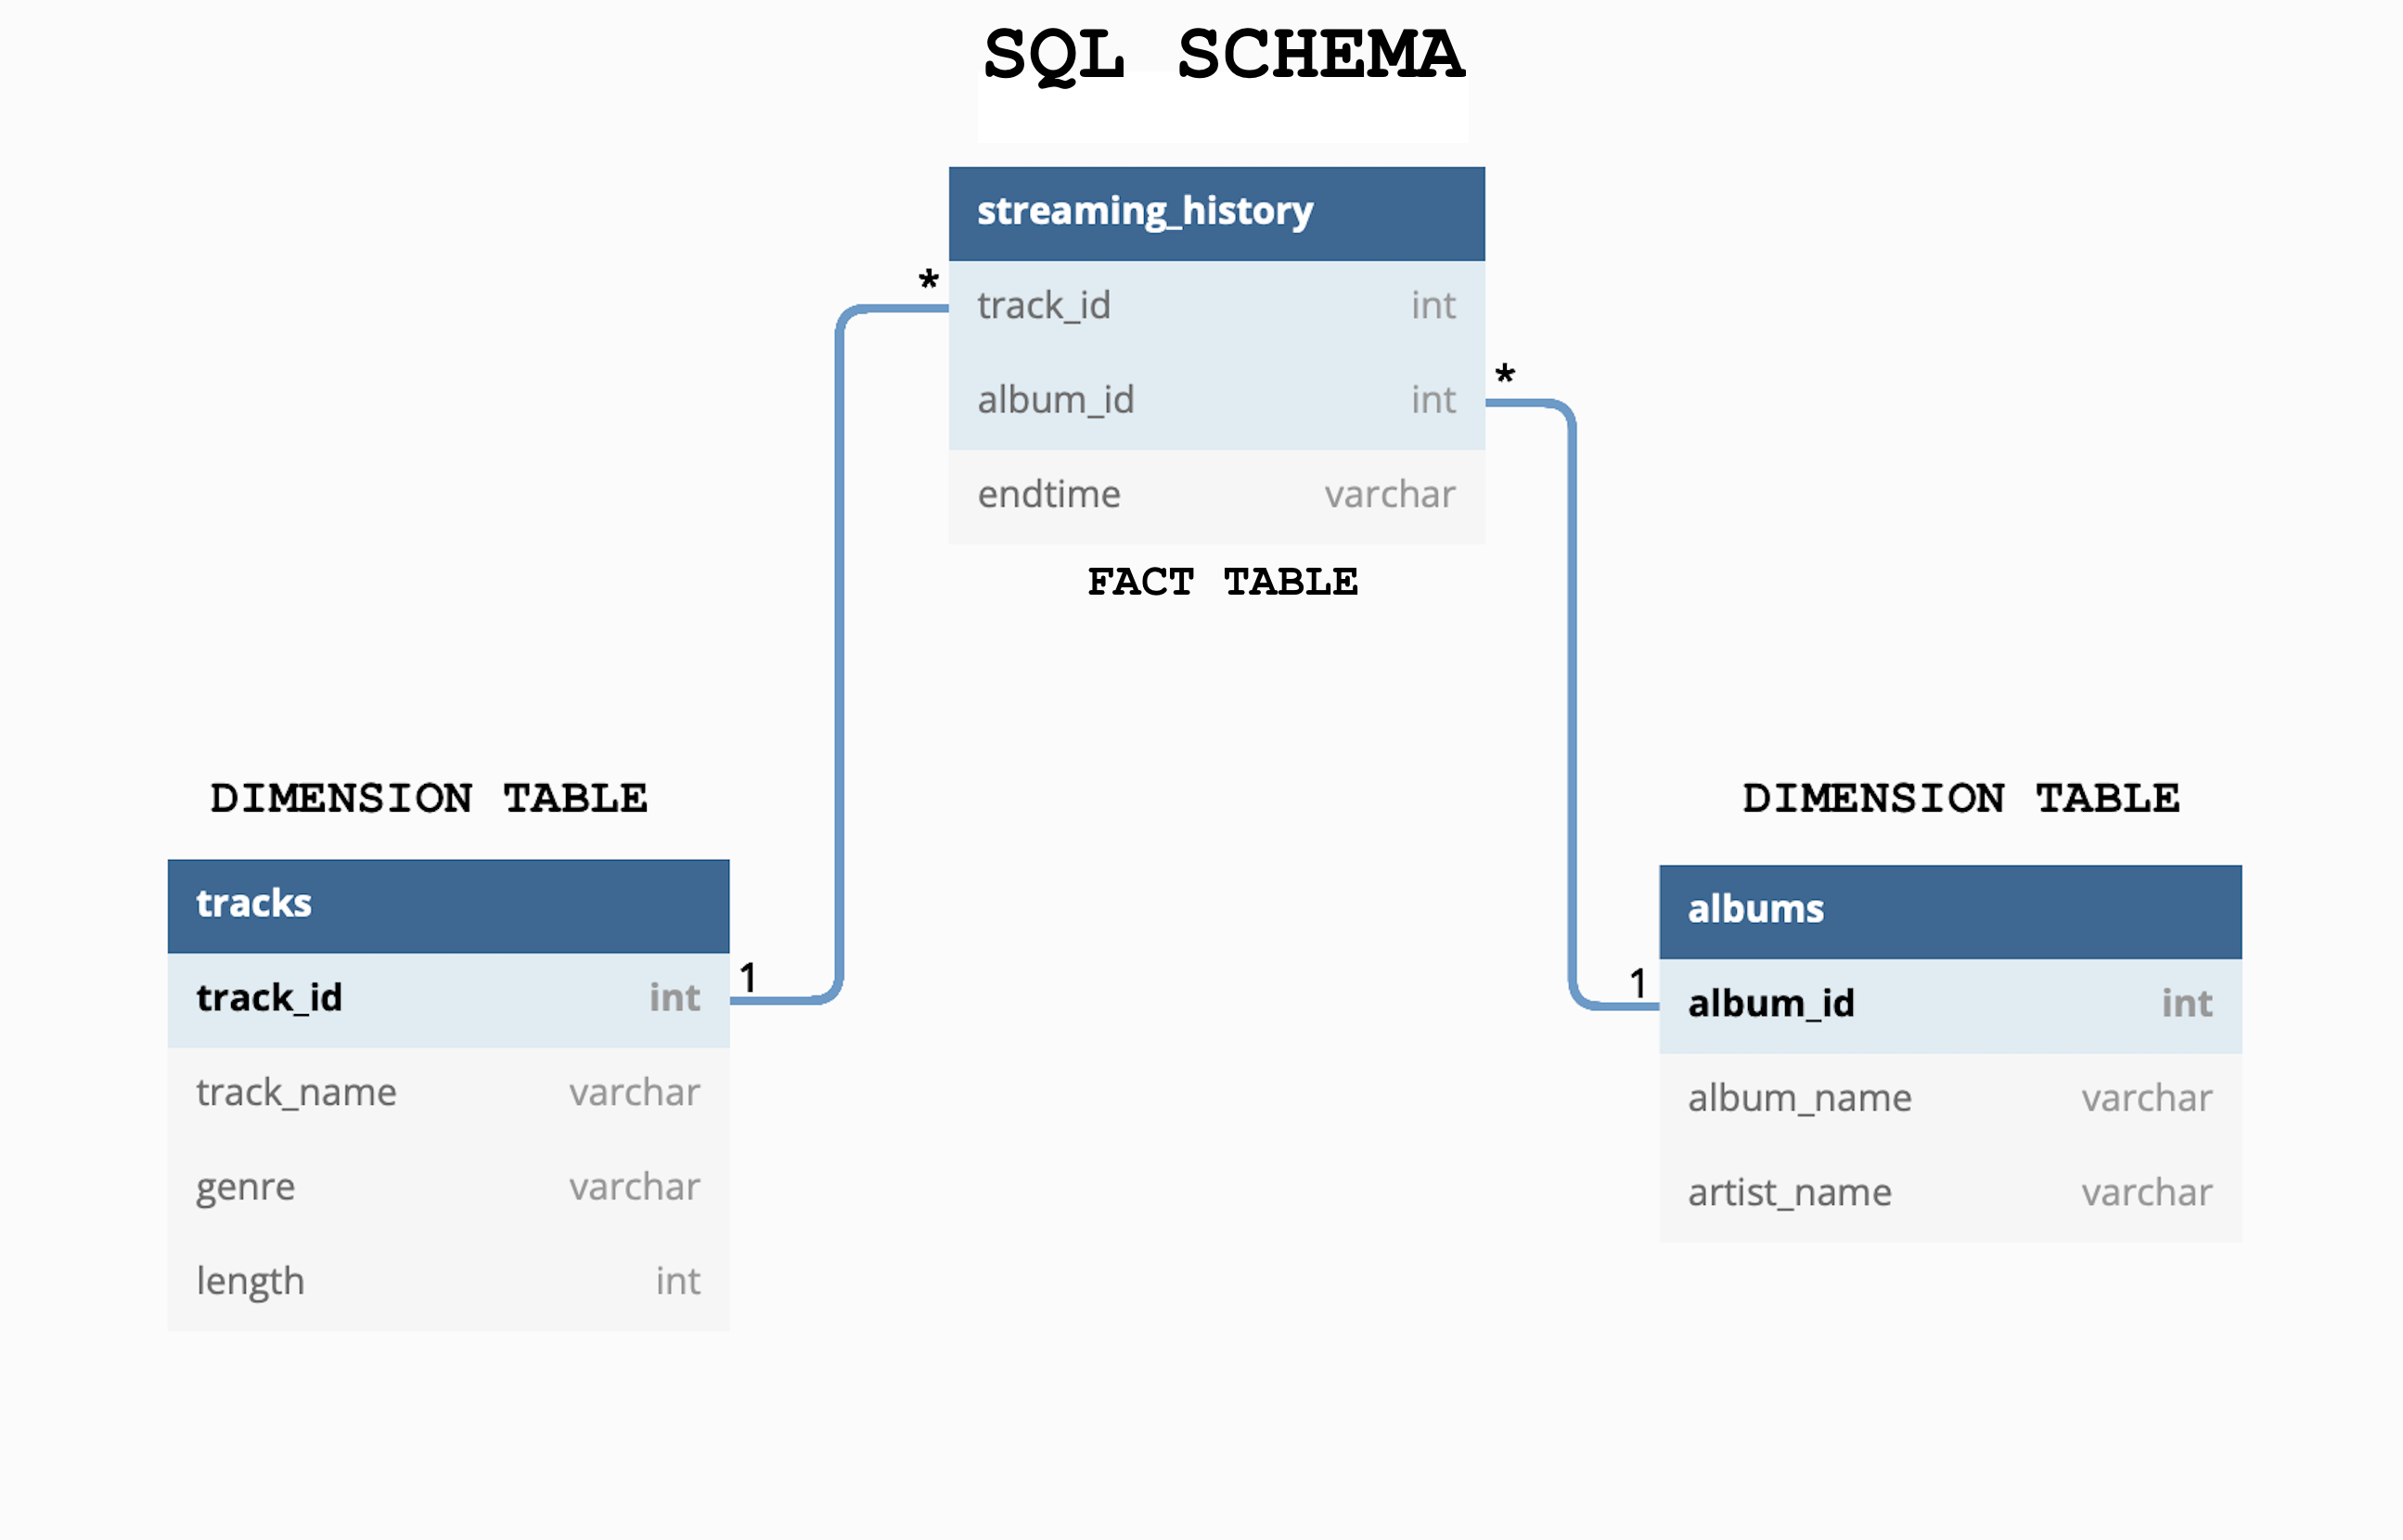

### **2.7 QUERIES**
Queries below are ordered by increasing level of difficulty. Since the database uses a star-shape schema for optimization, all of the queries use joins. Other important SQL concepts mentioned are window functions, subqueries, common table expressions (CTEs) and "case" clauses.

To visualize the queries, pandas "read_sql_query" function will be used, since it nicely prints the results (just like on 2.6). Also, for some queries, a visualization will be added for completeness sake.

---

1. How many times was "Lose Yourself" by Eminem played?
2. Which Muse songs were listened?
3. How many times was Foo Fighters listened (in other words, how many times were their songs listened in total)?
4. How many different genres were mentioned on the streaming history? And which was the most listened genre?
5. What are the top three most listened artists?
6. What are the top three most listened songs?
7. What about the the top three most listened albums?
8. What was the most listened genre?
9. Which was the most listened song by month?
10. Who was the most listened artist by month?
11. Which artist had more unique songs played?
12. Which album had more unique songs played?
13. Which song was repeated most times (listened to in sequence)?

### 2.7.1. How many times was "Lose Yourself" by Eminem played?

In [12]:
query = '''SELECT track_name, count(track_name) as times_listened FROM streaming_history AS sh
           JOIN tracks AS t ON t.track_id = sh.track_id
           JOIN albums AS a ON a.album_id = sh.album_id
           WHERE track_name = 'Lose Yourself';'''
print(pd.read_sql_query(query, connection))

      track_name  times_listened
0  Lose Yourself               8


### 2.7.2. Which Muse songs were listened?

In [13]:
query = '''SELECT DISTINCT a.artist, t.track_name FROM streaming_history AS sh
           JOIN tracks AS t ON t.track_id = sh.track_id
           JOIN albums AS a ON a.album_id = sh.album_id
           WHERE a.artist = 'Muse';'''
print(pd.read_sql_query(query, connection))

  artist               track_name
0   Muse                 Hysteria
1   Muse                 Uprising
2   Muse  Supermassive Black Hole


### 2.7.3. How many times was Foo Fighters listened (in other words, how many times were their songs listened in total)?

In [14]:
query = '''SELECT artist, count(a.artist) as times_listened FROM streaming_history as sh
           JOIN albums as a ON sh.album_id = a.album_id
           WHERE  a.artist = 'Foo Fighters';'''
print(pd.read_sql_query(query, connection))


         artist  times_listened
0  Foo Fighters              49


### 2.7.4.a. How many different genres were mentioned on the streaming history?

In [15]:
query = '''SELECT count(DISTINCT genre) AS genres FROM tracks;'''
print(pd.read_sql_query(query, connection), '\n')

   genres
0      17 



### 2.7.4.b. And which was the most listened genre?

In [16]:
query = '''SELECT genre, count(genre) as times_played FROM streaming_history AS sh
           JOIN tracks as t on t.track_id = sh.track_id
           GROUP BY genre ORDER BY times_played DESC
           LIMIT 1;'''
print(pd.read_sql_query(query, connection), '\n')

# The query above, however fine, assumes that there is only one genre at the top (there is no tie between genres) or even if there is a tie between genres at the top, 
# returning any one of them is fine. The alternative below considers the possibility that there may be more than one genre at the top and returns all genres at the top 1.

query = '''WITH cte as(
           SELECT genre, count(genre) as times_played
           FROM streaming_history AS sh
           JOIN tracks as t ON t.track_id = sh.track_id
           GROUP BY genre)
           
           SELECT * FROM
           		(SELECT *, rank() OVER (ORDER BY times_played DESC)  as rnk FROM cte)
           WHERE rnk < 2'''
print(pd.read_sql_query(query, connection))

# Besides dealing with ties between top genres, the query above is also a good example of some relatively more advanced SQL concepts, such as windows funcions,
# common table expressions and subqueries. This is the approach which will be used from now on.

              genre  times_played
0  Alternative Rock            69 

              genre  times_played  rnk
0  Alternative Rock            69    1


### 2.7.5. What are the top three most listened artists?

In [17]:
query = '''SELECT rnk, artist, times_played FROM (
           		SELECT *, RANK () OVER (ORDER BY times_played DESC) as rnk FROM (
           				SELECT *, count(artist) as times_played FROM streaming_history AS sh
           				JOIN albums AS a ON a.album_id = sh.album_id
           				GROUP BY artist))
           WHERE rnk  < 4;'''
data = pd.read_sql_query(query, connection)
print(data)

   rnk        artist  times_played
0    1  Carlos Vives            57
1    2  Foo Fighters            49
2    3    Ed Sheeran            35


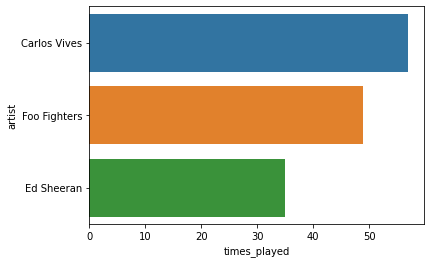

In [18]:
ax = sns.barplot(data=data, x='times_played', y='artist')

### 2.7.6. What are the top three most listened songs?

In [18]:
query = '''WITH cte AS (
           		SELECT artist, track_name, count(track_name) as times_played FROM streaming_history AS sh
           		JOIN tracks AS t ON t.track_id = sh.track_id
           		JOIN albums AS a ON a.album_id = sh.album_id
           		GROUP BY track_name)
           
           SELECT rnk, times_played, track_name, artist FROM (
           		SELECT *, DENSE_RANK() OVER (ORDER BY times_played DESC)  as rnk FROM cte)
           WHERE rnk < 4 ORDER BY rnk ASC;'''
data = pd.read_sql_query(query, connection)
print(data)

   rnk  times_played     track_name        artist
0    1            44   Fruta Fresca  Carlos Vives
1    2            25        Outside  Foo Fighters
2    3             8  Lose Yourself        Eminem


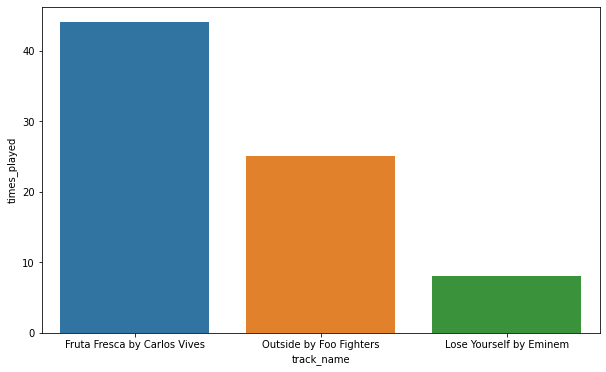

In [19]:
tick_labels = data['track_name'] + ' by ' + data['artist']
ax = plt.figure(figsize=(10,6))
ax = sns.barplot(data=data, x='track_name', y='times_played')
ax.set_xticklabels(tick_labels)
plt.show()

### 2.7.7. What about the the top three most listened albums?

In [21]:
query = '''SELECT rnk, album_name, artist, times_played FROM (
           		SELECT *, RANK () OVER (ORDER BY times_played DESC) as rnk FROM (
           				SELECT *, count(album_name) as times_played FROM streaming_history AS sh
           				JOIN albums AS a ON a.album_id = sh.album_id
           				GROUP BY album_name))
           WHERE rnk  < 4;'''
data = pd.read_sql_query(query, connection)
print(data)

   rnk            album_name        artist  times_played
0    1  El Amor de Mi Tierra  Carlos Vives            45
1    2        Sonic Highways  Foo Fighters            26
2    3                     =    Ed Sheeran            15


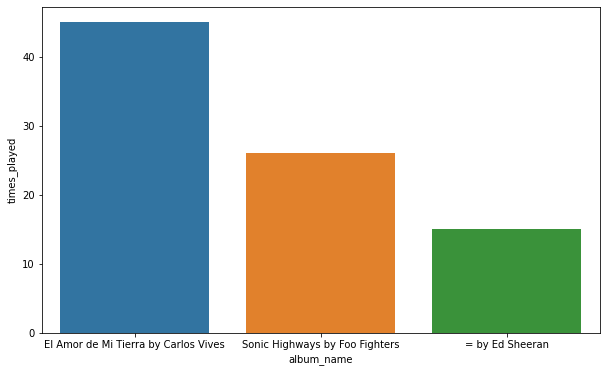

In [22]:
tick_labels = data['album_name'] + ' by ' + data['artist']
ax = plt.figure(figsize=(10,6))
ax = sns.barplot(data=data, x='album_name', y='times_played')
ax.set_xticklabels(tick_labels)
plt.show()
# It is possible to see here great correlation between the most listened songs and the most listened albums. Not only the artists on the top three are the same, but the shapes
# of the charts are very similar.

### 2.7.8. What was the most listened genre?

In [23]:
query = '''SELECT rnk, genre, times_played FROM (
           		SELECT *, ROW_NUMBER () OVER (ORDER BY times_played DESC) as rnk FROM (
           				SELECT *, count(genre) as times_played FROM streaming_history AS sh
           				JOIN tracks AS t ON t.track_id = sh.track_id
           				GROUP BY genre))
           WHERE rnk  < 2;'''
print(pd.read_sql_query(query, connection))

# The ROW_NUMBER() function is employed here. Having almost the same purpose as RANK(), ROW_NUMBER() does not give the same rank to two entries (even if they have the same 
# times_played) and also does not skip ranks, just like DENSE_RANK().

   rnk             genre  times_played
0    1  Alternative Rock            69


### 2.7.9. Which was the most listened song by month?

In [24]:
query = '''WITH cte AS (
					            		SELECT (strftime('%Y',endtime)  ||  '-'  || strftime('%m',endtime) ) as month, track_name, artist
					            		FROM streaming_history AS sh
					            		JOIN tracks AS t on t.track_id = sh.track_id
					 				JOIN albums AS a ON a.album_id = sh.album_id)
					 
					            SELECT * FROM (							
					            		SELECT *, DENSE_RANK() OVER (PARTITION BY month ORDER BY times_played DESC ) as rnk FROM (
					            				SELECT *, count(month) times_played FROM cte
					            				GROUP BY track_name, month))
					            WHERE rnk < 4
					 		   ORDER BY month'''
data = pd.read_sql_query(query, connection)
print(data)

# This query shows datetime manipulation and nested subqueries.

# It is important to note here that using the window function "rank" the albums with the same number of times played had the same rnk. Therefore, even though the query 
# filtered all songs below rnk = 4, more than three songs were returned for April and May. This is the expected behavior and not a bug. In case only three (or any other 
# number) of records should be displayed, one should make use of the "row_number" function, as shown in 2.7.8.

      month            track_name          artist  times_played  rnk
0   2022-03          Fruta Fresca    Carlos Vives            28    1
1   2022-03               Outside    Foo Fighters            20    2
2   2022-03                  Walk    Foo Fighters             6    3
3   2022-04          Fruta Fresca    Carlos Vives            13    1
4   2022-04          Shape of You      Ed Sheeran             4    2
5   2022-04               Shivers      Ed Sheeran             4    2
6   2022-04     Overpass Graffiti      Ed Sheeran             3    3
7   2022-04              good 4 u  Olivia Rodrigo             3    3
8   2022-05             All of Me     John Legend             5    1
9   2022-05         Lose Yourself          Eminem             5    1
10  2022-05               Rap God          Eminem             5    1
11  2022-05      Forgot About Dre         Dr. Dre             4    2
12  2022-05               Outside    Foo Fighters             4    2
13  2022-05          Fruta Fresca 

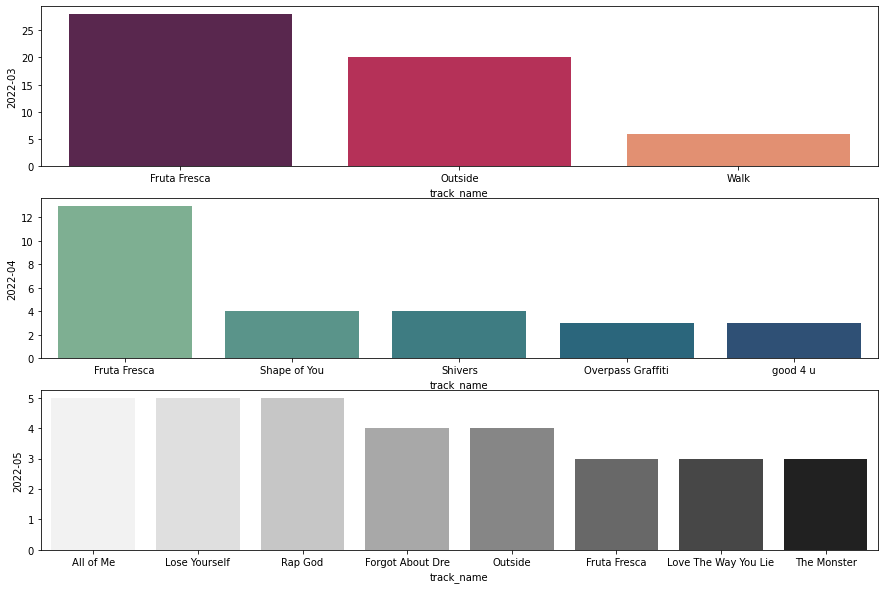

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=False)
sns.barplot(x = data[data['month'] == '2022-03']['track_name'], y = data[data['month'] == '2022-03']['times_played'], palette="rocket", ax=ax1)
ax1.set_ylabel("2022-03")
sns.barplot(x = data[data['month'] == '2022-04']['track_name'], y = data[data['month'] == '2022-04']['times_played'], palette="crest", ax=ax2)
ax2.set_ylabel("2022-04")
sns.barplot(x = data[data['month'] == '2022-05']['track_name'], y = data[data['month'] == '2022-05']['times_played'], palette="Greys", ax=ax3)
ax3.set_ylabel("2022-05")
plt.show()

### 2.7.10. Who were the most listened artists by month?

In [26]:
query = '''WITH cte AS (
					            		SELECT artist, (strftime('%Y',endtime)  ||  '-'  || strftime('%m',endtime) ) as month
					            		FROM streaming_history AS sh
					            		JOIN albums AS a on a.album_id = sh.album_id)
					 
					 		   
					 SELECT month, rnk, num_played, artist FROM (							
					            		SELECT *, DENSE_RANK() OVER (PARTITION BY month ORDER BY num_played DESC ) as rnk FROM (
					            				SELECT *, count(month) num_played FROM cte
					            				GROUP BY artist, month))
					 WHERE rnk < 4 
					 ORDER BY month , rnk ASC;'''
data = pd.read_sql_query(query, connection)
print(data, '\n')

     month  rnk  num_played         artist
0  2022-03    1          41   Carlos Vives
1  2022-03    2          39   Foo Fighters
2  2022-03    3          13     Ed Sheeran
3  2022-04    1          20     Ed Sheeran
4  2022-04    2          13   Carlos Vives
5  2022-04    3           4   Foo Fighters
6  2022-05    1          21         Eminem
7  2022-05    2           8  Ariana Grande
8  2022-05    3           6   Foo Fighters 



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


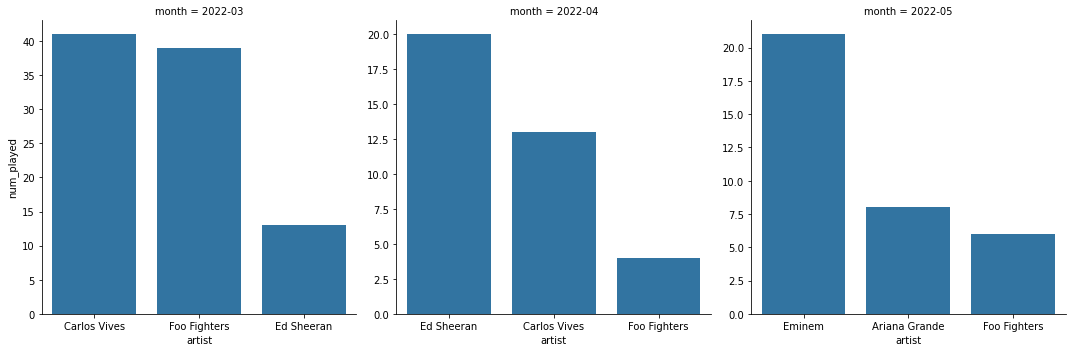

In [27]:
ax = sns.FacetGrid(data, col="month", height = 5, sharex=False, sharey = False)
ax.map(sns.barplot, "artist", "num_played")
plt.show()

### 2.7.11. Which five artists had the most unique songs played?

In [29]:
query = '''SELECT * FROM (
           		SELECT *, RANK () OVER (ORDER BY times_played DESC)  as rnk FROM (
           				SELECT  artist, count(DISTINCT track_id) AS times_played FROM streaming_history AS sh
           				JOIN albums AS a ON a.album_id = sh.album_id
           				GROUP BY artist ORDER BY times_played DESC))
           WHERE rnk < 6;'''
print(pd.read_sql_query(query, connection))

# rnk returned more artist than assumed at first, at per explained in 2.7.9.

          artist  times_played  rnk
0   Foo Fighters            12    1
1     Ed Sheeran            10    2
2   Carlos Vives            10    2
3     The Weeknd             8    4
4         Eminem             8    4
5  Ariana Grande             8    4


### 2.7.12. Which album had more unique songs played?

In [30]:
query = '''SELECT * FROM (
           		SELECT *, RANK () OVER (ORDER BY times_played DESC)  as rnk FROM (
           				SELECT  album_name,artist, count(DISTINCT track_id) AS times_played FROM streaming_history AS sh
           				JOIN albums AS a ON a.album_id = sh.album_id
           				GROUP BY album_name ORDER BY times_played DESC))
           WHERE rnk < 2;'''
print(pd.read_sql_query(query, connection))

         album_name        artist  times_played  rnk
0  Corazón Profundo  Carlos Vives             4    1
1                 =    Ed Sheeran             4    1


### 2.7.13. Which song was repeated most times (listened to in sequence)?

In [34]:
query = '''WITH cte AS(
           		SELECT grp, track_name, count(flag) as times_played_in_sequence, RANK() OVER (ORDER BY count(flag) DESC) AS rnk FROM (		
           				SELECT *, SUM(flag) OVER (ORDER BY endtime) AS grp FROM (
           						SELECT *, CASE WHEN (track_name <> last_track) THEN 1 ELSE 0 END flag FROM (	
           								SELECT endtime, track_name, LAG(track_name, 1, 0) OVER () AS last_track FROM streaming_history AS sh
           								JOIN tracks AS t ON t.track_id = sh.track_id)))
           		GROUP by grp ORDER BY COUNT(flag) DESC)
           
           SELECT track_name, times_played_in_sequence FROM cte
           WHERE rnk < 2;'''
print(pd.read_sql_query(query, connection))

# On the second inner-most query, "CASE-WHEN" was used for exemplification, but could have been substituted by a simple comparison.

     track_name  times_played_in_sequence
0  Fruta Fresca                        11


### **2.8 CLOSES CURSOR AND CONNECTION**

In [35]:
cursor.close()
connection.close()